In [1]:
%matplotlib inline

In [2]:
# FOOOF, and custom helper & utility functions
from fooof import FOOOF, FOOOFGroup
from fooof.objs import average_fg
from fooof.plts import plot_spectrum
from fooof.utils import trim_spectrum
from fooof.data import FOOOFSettings
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.core.funcs import expo_nk_function
import numpy as np
import pandas as pd
# MNE & associated code
import mne
from mne.preprocessing import ICA, read_ica
from mne.utils import _time_mask

from autoreject import AutoReject, read_auto_reject
from autoreject.autoreject import _apply_interp

from scipy.stats import ttest_ind, pearsonr, normaltest

In [3]:
import sys


import scipy.io as spio


#Function to import mat file to 
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [4]:
#Import Power Spectrum Density plots 

#Older group
PSDs = loadmat('PSDs.mat')

#Younger group
PSDsYoung = loadmat('PSDsYoung.mat')

C:\Users\user\AppData\Local\Temp\ipykernel_23508\664692765.py:24: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
C:\Users\user\AppData\Local\Temp\ipykernel_23508\664692765.py:35: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):


In [5]:
# Initialize a FOOOFGroup object, which accepts all the same settings as FOOOF
fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, max_n_peaks=6, peak_threshold=1.5, aperiodic_mode = 'fixed')

In [6]:
#Extract Power values from PSD files and save them in a dictionary
PowersRest = dict()
word = 'Power'
for key in PSDs['PSDs'].keys():
    if word in key:
        PowersRest[key] = np.array(PSDs['PSDs'][key])

#Extract Channel names from PSD files and save them in a dictionary
ChannelsRest = dict()
word = 'Channels'
for key in PSDs['PSDs'].keys():
    if word in key:
        ChannelsRest[key] = np.array(PSDs['PSDs'][key])

#Extract Frequency values from PSD files and save them in a dictionary
FreqsRest = PSDs['PSDs']['Freqs_AD0109_S1_Rest']

#Extract power values, channel names, and frequency values from Young PSD files
PowersRestYoung = dict()
word = 'Power'
for key in PSDsYoung['PSDsYoung'].keys():
    if word in key:
        PowersRestYoung[key] = np.array(PSDsYoung['PSDsYoung'][key])

ChannelsRestYoung = dict()
word = 'Channels'
for key in PSDsYoung['PSDsYoung'].keys():
    if word in key:
        ChannelsRestYoung[key] = np.array(PSDsYoung['PSDsYoung'][key])

FreqsRestYoung = PSDsYoung['PSDsYoung']['Freqs_MA0901_S1_Rest']

In [139]:
# Initialize input variables for fooof group object
# To only visualize one subject, one session across channels
spectra = PSDs['PSDs']['Power_AD0109_S1_Rest']
freqs = PSDs['PSDs']['Freqs_AD0109_S1_Rest']
channels = PSDs['PSDs']['Channels_AD0109_S1_Rest']
print(channels[11])

C3


In [8]:
# Fit a group of power spectra with the .fit() method from 3 to 40 Hz
fg.fit(freqs, spectra, [3, 40])

Running FOOOFGroup across 63 power spectra.


                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 63                             
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

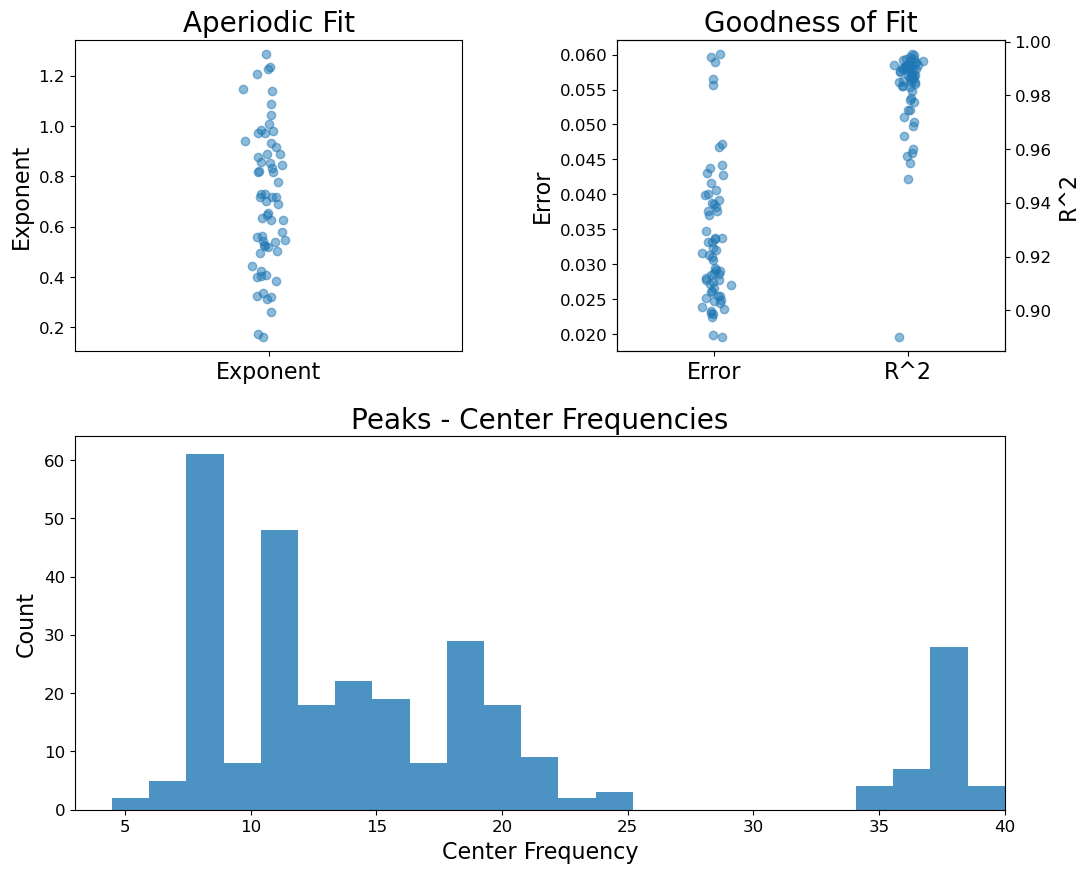

In [10]:
# Print out and plot results for one subject and one session across different cvhannels
fg.print_results()
fg.plot()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                        -13.1014, -0.1136                                         
                                                                                                  
                                       4 peaks were found:                                        
          

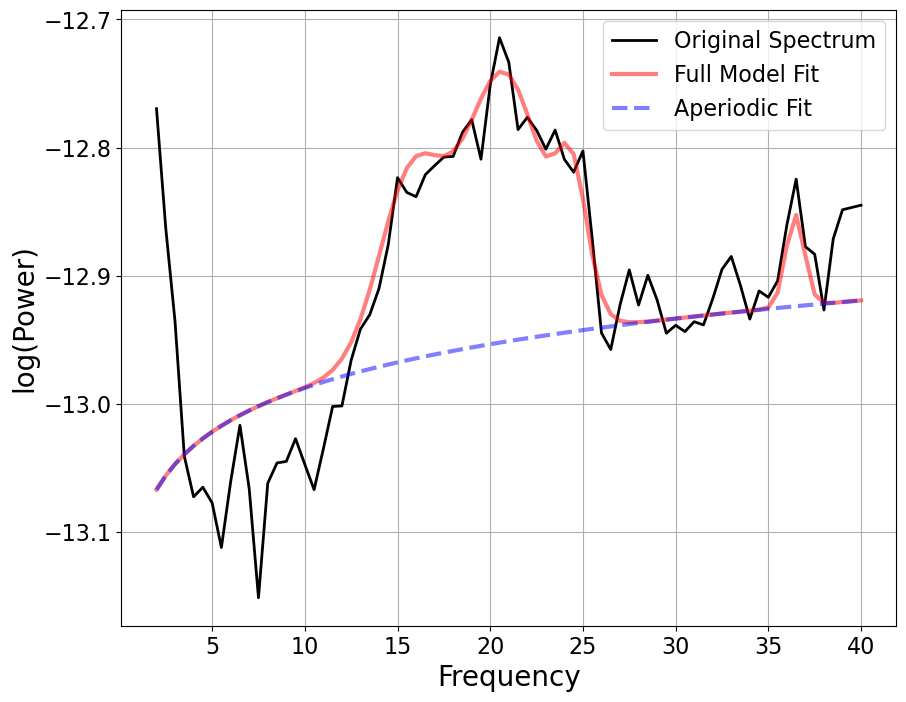

In [140]:
# Extract a particular spectrum, specified by index so you can visualize the fit in just one channel 
#  Here we also specify to regenerate the the full model fit, from the results
fm = fg.get_fooof(ind=11, regenerate=True)

# Print results and plot extracted model fit
fm.print_results()
fm.plot()

In [13]:
freq_range = [2, 40]

# Initialize a FOOOFGroup object for old participants, which accepts all the same settings as FOOOF
fgOLD = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, max_n_peaks=6, peak_threshold=1.5, aperiodic_mode = 'fixed')
# Initialize a FOOOFGroup object for young participants, which accepts all the same settings as FOOOF
fgYoung = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, max_n_peaks=6, peak_threshold=1.5, aperiodic_mode = 'fixed')

fgs = []
for key in PowersRest.keys():
    fgOLD.fit(FreqsRest, PowersRest[key], freq_range, progress='tqdm.notebook')
    fgOLD.save('FG_results' + key, save_settings=True, save_results=True)
    fgs.append(fgOLD.copy())

fgsYoung = []
for key in PowersRestYoung.keys():
    fgYoung.fit(FreqsRestYoung, PowersRestYoung[key], freq_range, progress='tqdm.notebook')
    fgYoung.save('FG_resultsYoung' + key, save_settings=True, save_results=True)
    fgsYoung.append(fgYoung.copy())

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/64 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/64 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/64 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/62 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/61 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/62 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/64 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/61 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/64 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/61 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/60 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/59 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/59 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/63 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/64 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/61 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/61 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/58 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/59 [00:00<?, ?it/s]

Running FOOOFGroup:   0%|          | 0/61 [00:00<?, ?it/s]

In [151]:
# Set whether to drop outlier subjects, in terms of FOOOF Goodness-of-Fit metrics
drop_outliers = False

# Set average function to use
avg_func = np.nanmean

# Wether to save out plots or not
SAVE_FIG = False

# Set FOOOF peak params label
peak_label = 'peak_params' # 'peak_params', 'gaussian_params'

# Create two list with the names of the channel for each subject
label = list(ChannelsRest.keys())
labelYoung = list(ChannelsRestYoung.keys())

In [157]:
# Extract alphas from each subject in the old group
alphas = np.empty(shape=[len(fgs), 3])
for ind, fgOLD in enumerate(fgs):
    for sub in ChannelsRest[label[ind]]:
        lista = ChannelsRest[label[ind]].tolist()
        if 'C3' in lista:
            ch_ind = lista.index('C3')
        elif 'C1' in lista:
            ch_ind = lista.index('C1')
    alphas[ind, :] = get_band_peak_fg(fgOLD, [7, 14], attribute=peak_label)[ch_ind, :]

# Extract alphas from each subject in the young group
alphasYoung = np.empty(shape=[len(fgsYoung), 3])
for ind, fgYoung in enumerate(fgsYoung):
    for sub in ChannelsRestYoung[labelYoung[ind]]:
        lista = ChannelsRestYoung[labelYoung[ind]].tolist()
        if 'C3' in lista:
            ch_indYoung = lista.index('C3')
        elif 'C1' in lista:
            ch_indYoung = lista.index('C1')
    alphasYoung[ind, :] = get_band_peak_fg(fgYoung, [7, 14], attribute=peak_label)[ch_indYoung, :]
    


In [159]:
# Extract aperiodic parameters for each subject in the old group
aps = np.empty(shape=[len(fgs), 2])

for ind, fgOLD in enumerate(fgs):
    for sub in ChannelsRest[label[ind]]:
        lista = ChannelsRest[label[ind]].tolist()
        if 'C3' in lista:
            ch_ind = lista.index('C3')
        elif 'C1' in lista:
            ch_ind = lista.index('C1')
    aps[ind, :] = fgOLD.get_params('aperiodic_params')[ch_ind]
offs = aps[:, 0]
exps = aps[:, 1]

# Extract aperiodic parameters for each subject in the young group
apsYoung = np.empty(shape=[len(fgsYoung), 2])
for ind, fgYoung in enumerate(fgsYoung):
    for sub in ChannelsRestYoung[labelYoung[ind]]:
        lista = ChannelsRestYoung[labelYoung[ind]].tolist()
        if 'C3' in lista:
            ch_indYoung = lista.index('C3')
        elif 'C1' in lista:
            ch_indYoung = lista.index('C1')
    apsYoung[ind, :] = fgYoung.get_params('aperiodic_params')[ch_indYoung]
offsYoung = apsYoung[:, 0]
expsYoung = apsYoung[:, 1]



In [152]:
# Extract error & R^2 from FOOOF fits for the old group
errs = []; r2s = []
for fg in fgs:
    errs.append(fg.get_results()[ch_ind].error)
    r2s.append(fg.get_results()[ch_ind].r_squared)

errs = np.array(errs)
r2s = np.array(r2s)

# Extract error & R^2 from FOOOF fits fo the young group
errsYoung = []; r2sYoung = []
for fgYoung in fgsYoung:
    errsYoung.append(fgYoung.get_results()[ch_indYoung].error)
    r2sYoung.append(fgYoung.get_results()[ch_indYoung].r_squared)

errsYoung = np.array(errsYoung)
r2sYoung = np.array(r2sYoung)

In [153]:
# Settings for outlier check
std_thresh = 2.5

In [154]:
def check_outliers(data, thresh):
    """Calculate indices of outliers, as defined by a standard deviation threshold."""

    return list(np.where(np.abs(data - np.mean(data)) > thresh * np.std(data))[0])


In [155]:
# Check for outliers using FOOOF Goodness of Fit metrics
err_outliers = check_outliers(errs, std_thresh)
std_outliers = check_outliers(r2s, std_thresh)

In [37]:
import warnings
import matplotlib.pyplot as plt
# Group colour settings
YNG_COL = "#0d82c1"
OLD_COL = "#239909"

In [38]:
# Check if the same outliers are detected for each GoF measure
print(err_outliers)
print(std_outliers)

[]
[]


In [39]:
def _set_lr_spines(ax, lw=None):
    """Set the spines to drop top & right box & set linewidth."""

    # Set the top and right side frame & ticks off
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Set linewidth of remaining spines
    if lw:
        ax.spines['left'].set_linewidth(lw)
        ax.spines['bottom'].set_linewidth(lw)

In [40]:
def plot_comp_scatter(dataold, datayoung, label=None, ylim=None, save_fig=False, save_name=None):
    """Create a scatter plot comparing the two groups."""

    fig, ax = plt.subplots(figsize=[2, 4])

    x1, x2 = 0.5, 1.5
    d1 = datayoung
    d2 = dataold

    # Create x-axis data, with small jitter for visualization purposes
    x_data_1 = np.ones_like(d1) * x1 + np.random.normal(0, 0.025, d1.shape)
    x_data_2 = np.ones_like(d2) * x2 + np.random.normal(0, 0.025, d2.shape)

    ax.scatter(x_data_1, d1, s=36, alpha=0.5, c=YNG_COL)
    ax.plot([x1-0.2, x1+0.2], [np.mean(d1), np.mean(d1)], lw=5, c=YNG_COL)

    ax.scatter(x_data_2, d2, s=36, alpha=0.5, c=OLD_COL)
    ax.plot([x2-0.2, x2+0.2], [np.mean(d2), np.mean(d2)], lw=5, c=OLD_COL)

    if label:
        ax.set_ylabel(label, fontsize=16)

    plt.xlim([0, 2])
    plt.xticks([x1, x2], ['Young', 'Old'])

    if ylim:
        plt.ylim(ylim)

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=10)

    _set_lr_spines(ax)
    #_save_fig(save_fig, save_name)

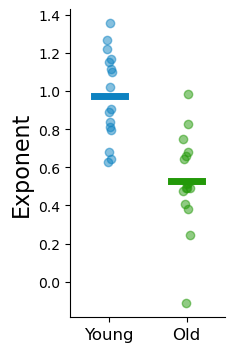

In [41]:
# Plot exponent comparison
plot_comp_scatter(exps, expsYoung, 'Exponent', save_fig=SAVE_FIG, save_name='exponents')

In [42]:
def cohens_d(d1, d2):
    """Calculate cohens-D: (u1 - u2)/SDpooled."""

    return (mean(d1) - mean(d2)) / (sqrt((stdev(d1) ** 2 + stdev(d2) ** 2) / 2))

def mean_diff(d1, d2):
    """Helper function to calculate mean differences."""

    return np.mean(d1) - np.mean(d2)

def print_stat(label, stat_val, p_val):
    """Helper function to print out statistical tests."""

    print(label + ': \t {: 5.4f} \t{: 5.4f}'.format(stat_val, p_val))
    
from statistics import mean, stdev
from math import sqrt

In [43]:
# Statistically test exponent difference
print_stat('Exponent t-test\t', *ttest_ind(expsYoung, exps))
print_stat('YNG / OLD means\t', np.mean(expsYoung), np.mean(exps))
print_stat('YNG / OLD stds\t', np.std(expsYoung), np.std(exps))
print_stat('abs / std diff\t', mean_diff(expsYoung, exps),
           cohens_d(expsYoung, exps))

Exponent t-test	: 	  5.2604 	 0.0000
YNG / OLD means	: 	  0.9761 	 0.5281
YNG / OLD stds	: 	  0.2247 	 0.2414
abs / std diff	: 	  0.4480 	 1.8598


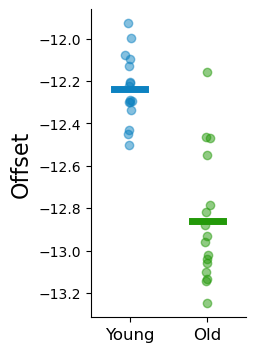

In [44]:
# Plot offset comparison
plot_comp_scatter(offs, offsYoung, 'Offset', save_fig=SAVE_FIG, save_name='Offsets')

In [45]:
# Statistically test offset difference
print_stat('Offset t-test\t', *ttest_ind(offsYoung, offs))
print_stat('YNG / OLD Means\t', np.mean(offsYoung), np.mean(offs))
print_stat('YNG / OLD stds\t', np.std(offsYoung), np.std(offs))
print_stat('abs / dtd diff\t', mean_diff(offsYoung, offs),
                               cohens_d(offsYoung, offs))

Offset t-test	: 	  7.2686 	 0.0000
YNG / OLD Means	: 	 -12.2353 	-12.8597
YNG / OLD stds	: 	  0.1561 	 0.2938
abs / dtd diff	: 	  0.6244 	 2.5698


In [177]:
# Collect the aperiodic parameters for each subject in the old group
cz_aps = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    for sub in ChannelsRest[label[ind]]:
        lista = ChannelsRest[label[ind]].tolist()
        if 'Cz' in lista:
            ch_ind = lista.index('Cz')
        elif 'C3' in lista:
            ch_ind = lista.index('C3')
    cz_aps[ind, :] = fg.get_params('aperiodic_params')[ch_ind]

In [181]:
# Collect the aperiodic parameters for each subject in the young group
cz_apsYoung = np.empty(shape=[len(fgsYoung), 2])
for ind, fg in enumerate(fgsYoung):
    for sub in ChannelsRest[label[ind]]:
        lista = ChannelsRest[label[ind]].tolist()
        if 'Cz' in lista:
            ch_indYoung = lista.index('Cz')
        elif 'C3' in lista:
            ch_indYoung = lista.index('C3')
    cz_apsYoung[ind, :] = fgYoung.get_params('aperiodic_params')[ch_indYoung]

In [48]:
# Calculate total alpha as the value of the aperiodic component at 
#   the alpha center frequency, plus the power of the alpha peak
tot_alphas = []
for ap, cf, pw in zip(c3_aps, alphas[:, 0], alphas[:, 1]):

    # If there is no alpha, get the aperiodic component at CF of 10
    #   and set alpha power to zero
    if np.isnan(cf):
        cf, pw = 10, 0
    
    # Calculate the value of aperiodic at the alpha-CF & add to the alpha-power
    tot_alphas.append(expo_nk_function(np.array([cf]), *ap)[0] + pw)
    
tot_alphas = np.array(tot_alphas)

In [49]:
# Calculate total alpha as the value of the aperiodic component at 
#   the alpha center frequency, plus the power of the alpha peak
tot_alphasYoung = []
for ap, cf, pw in zip(c3_apsYoung, alphasYoung[:, 0], alphasYoung[:, 1]):

    # If there is no alpha, get the aperiodic component at CF of 10
    #   and set alpha power to zero
    if np.isnan(cf):
        cf, pw = 10, 0
    
    # Calculate the value of aperiodic at the alpha-CF & add to the alpha-power
    tot_alphasYoung.append(expo_nk_function(np.array([cf]), *ap)[0] + pw)
    
tot_alphasYoung = np.array(tot_alphasYoung)

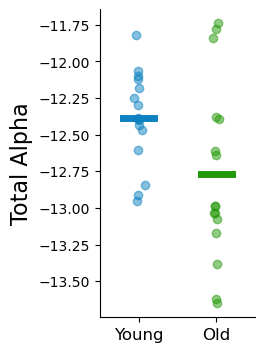

In [50]:
# Plot total alpha - total power values from the FOOOF model at individualzed alpha CFs
#  Note: this is equivalent to doing an individualed alpha frequency analysis, comparing total power
plot_comp_scatter(tot_alphas,tot_alphasYoung, 'Total Alpha',
                  save_fig=SAVE_FIG, save_name='TotalAlpha')

In [51]:
# Statistically test total 'alpha' difference
print_stat('Total Alpha t-test', *ttest_ind(tot_alphasYoung, tot_alphas))
print_stat('YNG / OLD means\t', np.mean(tot_alphasYoung), np.mean(tot_alphas))
print_stat('YNG / OLD stds\t', np.std(tot_alphasYoung), np.std(tot_alphas))
print_stat('abs / std diff\t', mean_diff(tot_alphasYoung, tot_alphas),
                             cohens_d(tot_alphasYoung, tot_alphas))

Total Alpha t-test: 	  2.2159 	 0.0344
YNG / OLD means	: 	 -12.3899 	-12.7712
YNG / OLD stds	: 	  0.3066 	 0.5918
abs / std diff	: 	  0.3813 	 0.7834


In [52]:
# Get the number of oscillations on the alpha channel in the old group
n_oscs = []
for fg in fgs:
    n_oscs.append(fg.get_results()[ch_ind].peak_params.shape[0])
n_oscs = np.array(n_oscs)

In [53]:
# Get the number of oscillations on the alpha channel in the young group
n_oscsYoung = []
for fgYoung in fgsYoung:
    n_oscsYoung.append(fgYoung.get_results()[ch_indYoung].peak_params.shape[0])
n_oscsYoung = np.array(n_oscsYoung)

In [54]:
# Statistically test number of peaks difference
print_stat('# of Peaks t-test', *ttest_ind(n_oscsYoung, n_oscs))
print_stat('YNG / OLD means\t', np.mean(n_oscsYoung), np.mean(n_oscs))
print_stat('YNG / OLD stds\t', np.std(n_oscsYoung), np.std(n_oscs))
print_stat('abs / std diff\t', mean_diff(n_oscsYoung, n_oscs),
                                 cohens_d(n_oscsYoung, n_oscs))

# of Peaks t-test: 	 -1.1004 	 0.2799
YNG / OLD means	: 	  4.0000 	 4.4375
YNG / OLD stds	: 	  1.1726 	 0.9980
abs / std diff	: 	 -0.4375 	 0.0000


In [55]:
# Check differences in alpha measures, between groups
for d_ind, label in zip([0, 1, 2], ['CF', 'PW', 'BW']):

    # Select data
    data = alphas[:, d_ind]
    dataYoung = alphasYoung[:, d_ind]
    yng_data = list(dataYoung[~np.isnan(dataYoung)])
    old_data = list(data[~np.isnan(data)])
    
    # Statistically compare and check average difference between groups
    print(label)
    print_stat('\tt-test', *ttest_ind(yng_data, old_data))
    print_stat('\tYNG/OLD means', np.mean(yng_data), np.mean(old_data))
    print_stat('\tYNG/OLD stds', np.std(yng_data), np.std(old_data))
    print_stat('\tabs/std diff', mean_diff(yng_data, old_data), cohens_d(yng_data, old_data))

CF
	t-test: 	  1.9199 	 0.0648
	YNG/OLD means: 	  10.4961 	 9.7597
	YNG/OLD stds: 	  0.8705 	 1.1807
	abs/std diff: 	  0.7364 	 0.6865
PW
	t-test: 	  2.4721 	 0.0195
	YNG/OLD means: 	  0.7561 	 0.4436
	YNG/OLD stds: 	  0.3071 	 0.3722
	abs/std diff: 	  0.3124 	 0.8855
BW
	t-test: 	  0.7304 	 0.4710
	YNG/OLD means: 	  1.9428 	 1.7420
	YNG/OLD stds: 	  0.8499 	 0.6011
	abs/std diff: 	  0.2009 	 0.2640


In [56]:
# Check how many subjects don't have alpha
print('Number of subjects with no alpha:')
print('\t YNG:\t', sum(np.isnan(dataYoung)))
print('\t OLD: \t', sum(np.isnan(data)))

Number of subjects with no alpha:
	 YNG:	 0
	 OLD: 	 1


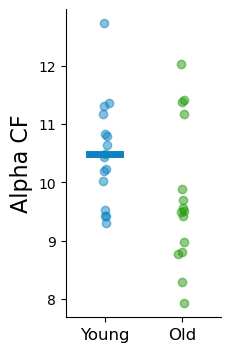

In [143]:
# Plot alpha center frequency comparison
plot_comp_scatter(alphas[:, 0],alphasYoung[:,0], 'Alpha CF',
                  save_fig=SAVE_FIG, save_name='AlphaCF')

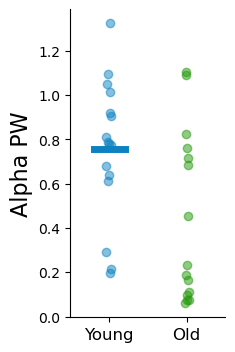

In [58]:
# Plot alpha power comparison
plot_comp_scatter(alphas[:, 1],alphasYoung[:,1], 'Alpha PW',
                  save_fig=SAVE_FIG, save_name='AlphaPW')

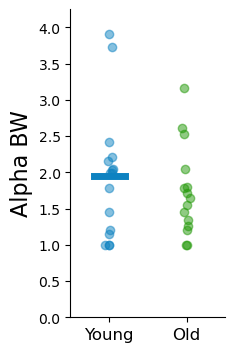

In [59]:
# Plot alpha bandwidth comparison
plot_comp_scatter(alphas[:, 2],alphasYoung[:,2], 'Alpha BW', ylim=[0, 4.25],
                  save_fig=SAVE_FIG, save_name='AlphaBW')

In [60]:
from fooof.core.errors import InconsistentDataError

def gaussian_function(xs, *params):
    """Gaussian fitting function.

    Parameters
    ----------
    xs : 1d array
        Input x-axis values.
    *params : float
        Parameters that define gaussian function.

    Returns
    -------
    ys : 1d array
        Output values for gaussian function.
    """

    ys = np.zeros_like(xs)

    for ii in range(0, len(params), 3):

        ctr, hgt, wid = params[ii:ii+3]

        ys = ys + hgt * np.exp(-(xs-ctr)**2 / (2*wid**2))

    return ys

def plot_oscillations(alphas, save_fig=False, save_name=None):
    """Plot a group of (flattened) oscillation definitions."""

    n_subjs = alphas.shape[0]

    # Initialize figure
    fig, ax = plt.subplots(figsize=[6, 6])

    # Get frequency axis (x-axis)
    fs = np.arange(6, 16, 0.1)

    # Create the oscillation model from parameters
    osc_psds = np.empty(shape=[n_subjs, len(fs)])
    for ind, alpha in enumerate(alphas):
        osc_psds[ind, :] = gaussian_function(fs, *alphas[ind, :])

    # Plot each individual subject
    for ind in range(n_subjs):
        ax.plot(fs, osc_psds[ind, :], alpha=0.3, linewidth=1.5)

    # Plot the average across all subjects
    avg = np.nanmean(osc_psds, 0)
    ax.plot(fs, avg, 'k', linewidth=3)

    ax.set_ylim([0, 1.75])

    ax.set_xlabel('Frequency', {'fontsize': 14})
    ax.set_ylabel('Power', {'fontsize': 14})

    # Set tick font-sizes
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)

    _set_lr_spines(ax, 2)
    #_save_fig(save_fig, save_name)

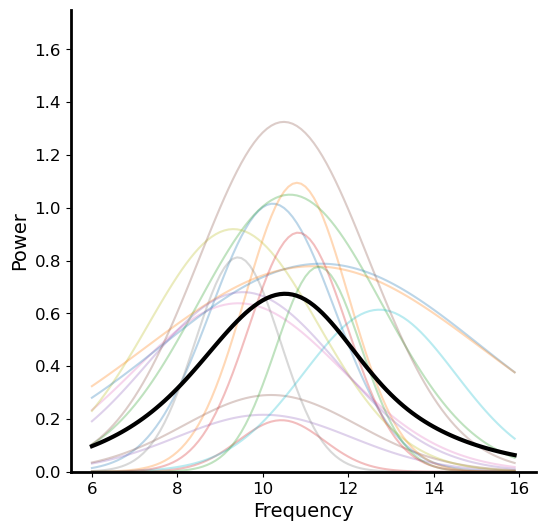

In [61]:
# Alpha peak reconstructions - YNG group
plot_oscillations(alphasYoung,
                  save_fig=SAVE_FIG, save_name='YoungAlphas')

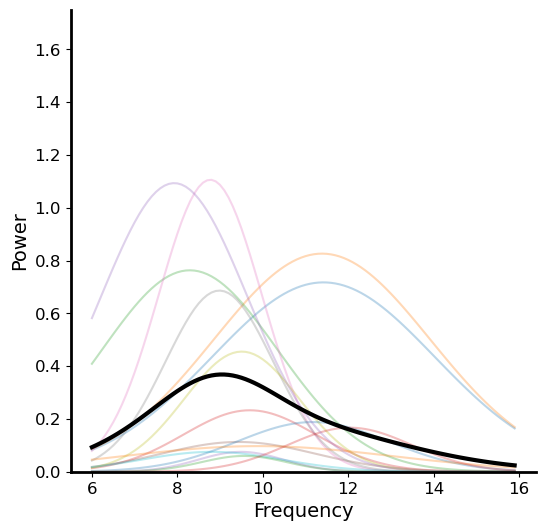

In [62]:
# Alpha peak reconstructions - OLD group
plot_oscillations(alphas,
                  save_fig=SAVE_FIG, save_name='OldAlphas')

In [63]:
from scipy.stats import pearsonr, norm, ttest_ind

In [64]:
def get_overlap(intersect, m1, m2, std1, std2):
    """Get the percent overlap of two gaussians, given their definitions, and intersection point."""

    return norm.cdf(intersect, m2, std2) + (1. - norm.cdf(intersect, m1, std1))

In [65]:
def get_intersect(m1, m2, std1, std2):
    """Gets the point of intersection of two gaussians defined by (m1, std1) & (m2, std2)"""

    a = 1. / (2.*std1**2) - 1. / (2.*std2**2)
    b = m2 / (std2**2) - m1 / (std1**2)
    c = m1**2 / (2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)

    return np.roots([a, b, c])[0]

In [66]:
def calc_overlaps(alphas):
    """Calculate the overlaps between gaussian defined peaks.

    The approach to do this is taken from:
    https://stackoverflow.com/questions/32551610/overlapping-probability-of-two-normal-distribution-with-scipy
    """

    # Note: current approach presumes no NaNs
    overlaps = []
    mean, std = 10, 2

    for alpha in alphas:

        # Get individual CF - keep BW @ 2
        ind_mean, ind_std = alpha[0], 2

        # Normalize all deviations from canonical to be lower than 10 Hz
        if ind_mean <= mean:
            m1, std1, m2, std2 = ind_mean, ind_std, mean, std
        else:
            m1, std1, m2, std2 = mean, std, ind_mean, ind_std

        intersect = get_intersect(m1, m2, std1, std2)
        overlap = get_overlap(intersect, m1, m2, std1, std2)

        overlaps.append(overlap)

    overlaps = np.array(overlaps)

    return overlaps


In [76]:
#Drop Nan values in the alphas array
new_alphas = alphas[np.isfinite(alphas)]

new_alphas.shape = (15, 3)

In [77]:
# Calculate overlaps
overlapsYoung = calc_overlaps(alphasYoung)
overlaps = calc_overlaps(new_alphas)

In [78]:
# Check average (overall) of overlaps, and stats
print('ALL avg overlap:  {:1.4f}'.format(np.mean(np.abs(np.concatenate((new_alphas,alphasYoung), axis=0)))), '\n')

print_stat('diff overlap\t', *ttest_ind(overlapsYoung, overlaps))
print_stat('YNG/OLD means\t', np.mean(overlapsYoung), np.mean(overlaps))
print_stat('abs/std diff\t', mean_diff(overlapsYoung, overlaps),
                             cohens_d(overlapsYoung, overlaps))

ALL avg overlap:  4.1968 

diff overlap	: 	  1.1812 	 0.2471
YNG/OLD means	: 	  0.8471 	 0.7965
abs/std diff	: 	  0.0507 	 0.4246


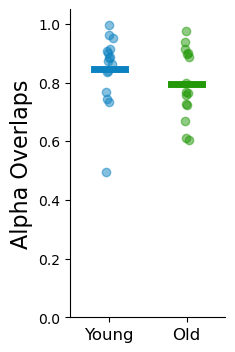

In [79]:
# Plot the overlaps of individual with canonical alpha, per group
plot_comp_scatter(overlaps, overlapsYoung,'Alpha Overlaps', ylim=[0, 1.05])

In [88]:
# Calculate the differences per subject from a 10 Hz center
old_overlaps = new_alphas[:, 0] - 10
yng_overlaps = alphasYoung[:, 0] - 10

In [89]:
# Print out average differences from 10 Hz
print('Directional Differences from 10 Hz Center, by Group:')
print('\tYNG-diff  {: 1.2f}'.format(np.mean(yng_overlaps)))
print('\tOLD-diff  {: 1.2f}'.format(np.mean(old_overlaps)))
print('\n')
print('Absolute Differences from 10 Hz Center, by Group:')
print('\tYNG-Diff  {: 1.2f}'.format(np.mean(np.abs(yng_overlaps))))
print('\tOLD-Diff  {: 1.2f}'.format(np.mean(np.abs(old_overlaps))))

Directional Differences from 10 Hz Center, by Group:
	YNG-diff   0.50
	OLD-diff  -0.24


Absolute Differences from 10 Hz Center, by Group:
	YNG-Diff   0.78
	OLD-Diff   1.04


In [97]:
# Get the average deviation from center of 10 Hz (across groups)
all_alphas = np.concatenate((new_alphas,alphasYoung))
avg_deviation = np.mean(np.abs(all_alphas[:,0] - 10))

In [98]:
# Get average deviation, per group
yng_deviation = np.mean(np.abs(new_alphas[:, 0] - 10))
old_deviation = np.mean(np.abs(alphasYoung[:, 0] - 10))

In [99]:
# Check the average deviations
print('ALL :\t {:1.4f}'.format(avg_deviation))
print('YNG :\t {:1.4f}'.format(yng_deviation))
print('OLD :\t {:1.4f}'.format(old_deviation))

ALL :	 0.9099
YNG :	 1.0438
OLD :	 0.7844


In [100]:
# Set up values for overalp analysis
vals_avg = (10 - avg_deviation, 10, 2, 2)
r_avg = get_intersect(*vals_avg)
vals_yng = (10 + yng_deviation, 10, 2, 2)
r_yng = get_intersect(*vals_yng)
vals_old = (10 - old_deviation, 10, 2, 2)
r_old = get_intersect(*vals_old)

In [101]:
# Check the average overlaps
print('ALL: \t {:1.4f}'.format(get_overlap(r_avg, *vals_avg)))
print('YNG: \t {:1.4f}'.format(get_overlap(r_yng, *vals_yng)))
print('OLD: \t {:1.4f}'.format(get_overlap(r_old, *vals_old)))

ALL: 	 0.8201
YNG: 	 1.2059
OLD: 	 0.8445


In [102]:
def plot_overlap(m1, m2, std1, std2, col='#2ba848', save_fig=False, save_name=None):
    """Visualize the overlap of two gaussians.

    m1 & std1 : define the average alpha
    m2 & std2 : define the canonical alpha
    """

    # Initialize plot & settings
    fig, ax = plt.subplots(figsize=[5, 6])
    ax.set_xlim([0, 20.])
    ax.set_ylim([0, 0.21])

    # Set up for x-axis
    x_vals = np.linspace(0, 20, 1000)
    step = x_vals[1] - x_vals[0]

    # Plot the gaussians
    plot1 = plt.plot(x_vals, norm.pdf(x_vals, m1, std1), 'grey', lw=2.5, label='Average')
    plot2 = plt.plot(x_vals, norm.pdf(x_vals, m2, std2), 'black', lw=2.5, label='Canonical')

    # Get point of overlap
    r_pt = get_intersect(m1, m2, std1, std2)

    #shade_col = '#d10c29'
    shade_col = 'grey'

    # Shade in overlapping areas
    alpha = 0.75
    if m1 < m2:
        _ = plt.fill_between(x_vals[x_vals > r_pt - step], 0,
                             norm.pdf(x_vals[x_vals > r_pt - step], m1, std1),
                             alpha=alpha, color=col, lw=0)
        _ = plt.fill_between(x_vals[x_vals < r_pt], 0,
                             norm.pdf(x_vals[x_vals < r_pt], m2, std2),
                             alpha=alpha, color=col, lw=0)
        _ = plt.fill_between(x_vals[x_vals < r_pt], norm.pdf(x_vals[x_vals < r_pt], m2, std2),
                             norm.pdf(x_vals[x_vals < r_pt], m1, std1),
                             alpha=alpha, color=shade_col, lw=0)
    else:
        _ = plt.fill_between(x_vals[x_vals < r_pt + step], 0,
                             norm.pdf(x_vals[x_vals < r_pt + step], m1, std1),
                             alpha=alpha, color=col, lw=0)
        _ = plt.fill_between(x_vals[x_vals > r_pt], 0,
                             norm.pdf(x_vals[x_vals > r_pt], m2, std2),
                             alpha=alpha, color=col, lw=0)
        _ = plt.fill_between(x_vals[x_vals > r_pt], norm.pdf(x_vals[x_vals > r_pt], m2, std2),
                             norm.pdf(x_vals[x_vals > r_pt], m1, std1),
                             alpha=alpha, color=shade_col, lw=0)

    _set_lr_spines(ax, 2)

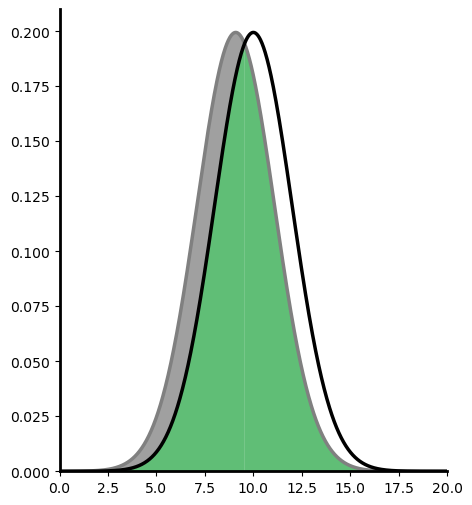

In [103]:
# Plot the overlap of canonical and average shifted alpha: ALL
plot_overlap(*vals_avg, save_fig=SAVE_FIG, save_name='CanonicalCompare-Avg')

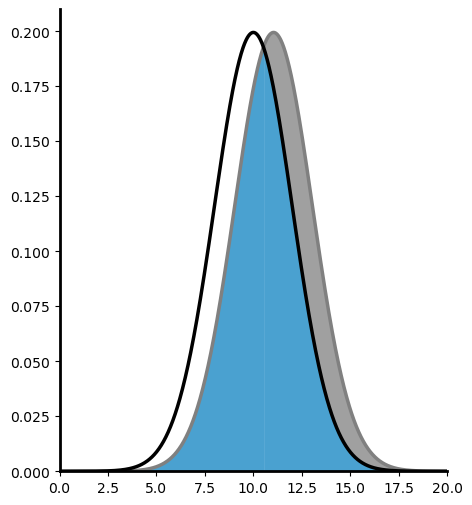

In [106]:
# Plot the overlap of canonical and average shifted alpha: YNG
plot_overlap(*vals_yng, col=YNG_COL)

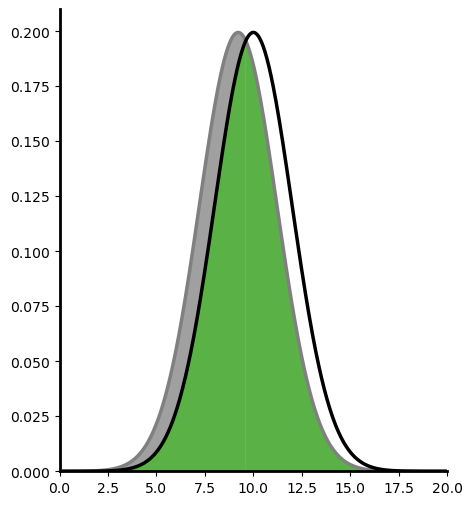

In [107]:
# Plot the overlap of canonical and average shifted alpha: OLD
plot_overlap(*vals_old, col=OLD_COL)

In [109]:
def plot_aperiodic(aps, apsYoung, control_offset=False, save_fig=False, save_name=None, return_vals=False):
    """Plot aperiodic components, comparing between groups."""

    n_subjs = aps.shape[0]
    n_subjsYoung = apsYoung.shape[0]

    # Set offset to be zero across all PSDs
    taps = np.copy(aps)
    tapsYoung = np.copy(apsYoung)
    
    if control_offset:
        taps[:, 0] = 1

    fig, ax = plt.subplots(figsize=[8, 6])

    # Get frequency axis (x-axis)
    fs = np.arange(1, 45, 0.1)

    # Create the aperiodic model from parameters
    ap_psds = np.empty(shape=[n_subjs, len(fs)])
    for ind, ap in enumerate(taps):
        ap_psds[ind, :] = expo_nk_function(fs, *taps[ind, :])
        
    ap_psdsYoung = np.empty(shape=[n_subjsYoung, len(fs)])
    for ind, ap in enumerate(taps):
        ap_psdsYoung[ind, :] = expo_nk_function(fs, *tapsYoung[ind, :])


    # Set whether to plot x-axis in log
    plt_log = False
    fs = np.log10(fs) if plt_log else fs

    # Plot each individual subject
    for ind in range(n_subjs):
        ax.plot(fs, ap_psds[ind, :], OLD_COL, alpha=0.2, linewidth=1.8)
    
    for ind in range(n_subjsYoung):
        ax.plot(fs, ap_psdsYoung[ind, :], YNG_COL, alpha=0.2, linewidth=1.8)

    # Plot the average across all subjects, split up by age group
    you_avg = np.mean(ap_psdsYoung, 0)
    old_avg = np.mean(ap_psds, 0)
    ax.plot(fs, you_avg, YNG_COL, linewidth=4, label='Young')
    ax.plot(fs, old_avg, OLD_COL, linewidth=4, label='Old')

    # Plot limits & labels
    ax.set_xlim([min(fs)-0.5, max(fs) + 0.5])
    ax.set_xlabel('Frequency', {'fontsize': 14, 'fontweight':'bold'})
    ax.set_ylabel('Power', {'fontsize': 14, 'fontweight':'bold'})

    # Set tick font-sizes
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)

    _set_lr_spines(ax, 2)
    #plt.legend()

    if return_vals:
        return fs

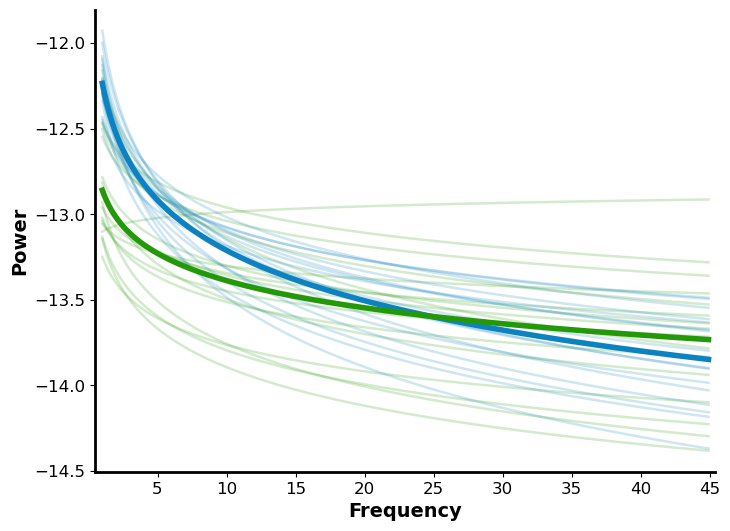

In [110]:
# Plot aperiodic component, comparing the power difference at each frequency
fs = plot_aperiodic(aps, apsYoung, return_vals=True,)

In [111]:
# Pull out the difference in power, at 10 Hz, arising from aperiodic difference
exp_alphas = []
for ap in aps:
    exp_alphas.append(expo_nk_function(np.array([10]), *ap)[0])
exp_alphas = np.array(exp_alphas)

exp_alphasYoung = []
for ap in apsYoung:
    exp_alphasYoung.append(expo_nk_function(np.array([10]), *ap)[0])
exp_alphasYoung = np.array(exp_alphasYoung)

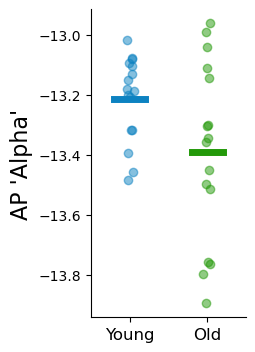

In [112]:
# Compare the 'alpha' difference - coming only from aperiodic differences
plot_comp_scatter(exp_alphas, exp_alphasYoung, "AP 'Alpha'",
                  save_fig=SAVE_FIG, save_name='APAlpha')

In [113]:
# Statistically test difference in 'AP-Alpha'
print_stat('AP-Al Diff', *ttest_ind(exp_alphasYoung, exp_alphas))

AP-Al Diff: 	  2.1268 	 0.0418


In [114]:
# Calculate aperiodic components of power spectra for each subject
freqs = range(2, 50, 2)
model_aps = []
for ap in aps:
    model_aps.append(expo_nk_function(np.array(freqs), *ap))
model_aps = np.array(model_aps)

freqs = range(2, 50, 2)
model_apsYoung = []
for ap in apsYoung:
    model_apsYoung.append(expo_nk_function(np.array(freqs), *ap))
model_apsYoung = np.array(model_apsYoung)

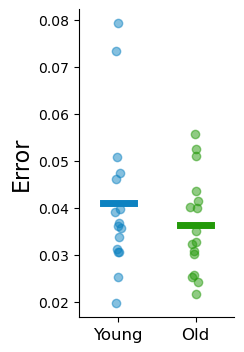

In [144]:
# Compare errors between groups
plot_comp_scatter(errs, errsYoung, "Error")

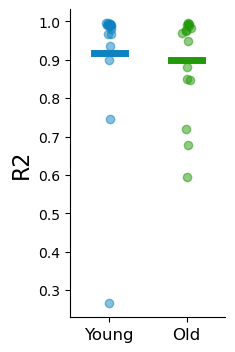

In [147]:
# Compare errors between groups
plot_comp_scatter(r2s, r2sYoung, "R2")

In [117]:
# Statistically compare errors and R^2 between groups
print_stat('Errors', *ttest_ind(errsYoung, errs))
print_stat('R-squared', *ttest_ind(r2sYoung, r2s))

Errors: 	  0.9571 	 0.3461
R-squared: 	  0.3369 	 0.7385


In [173]:
# Extract C3 aperiodic parameters old group
cz_offs = cz_aps[:, 0]
cz_exps = cz_aps[:, 1]
print(cz_offs)

[-11.77347379 -11.86979753 -11.69385468 -12.16172918 -12.38327324
 -11.78366809 -11.78280681 -12.0350476  -11.79014994 -12.20863268
 -12.16344191 -12.16792464 -12.41374938 -12.64744894 -11.72237153
 -11.92092597]


In [183]:
# Extract C3 aperiodic parameters young group
cz_offsYoung = cz_apsYoung[:, 0]
cz_expsYoung = cz_apsYoung[:, 1]

In [184]:
# Correlation between aperiodic features old group
print_stat('C3 - OFF  &  EXP ', *pearsonr(offs, exps))
print_stat('Cz - OFF  &  EXP ', *pearsonr(cz_offs, cz_exps))

C3 - OFF  &  EXP : 	  0.4246 	 0.1012
Cz - OFF  &  EXP : 	  0.8406 	 0.0000


In [186]:
# Correlation between aperiodic features young group
print_stat('C3 - OFF  &  EXP ', *pearsonr(offsYoung, expsYoung))
print_stat('Cz - OFF  &  EXP ', *pearsonr(cz_offsYoung, cz_expsYoung))

C3 - OFF  &  EXP : 	  0.7994 	 0.0002
Cz - OFF  &  EXP : 	  0.9660 	 0.0000


In [120]:
# Correlations between oscillation features old group
print_stat('CF  &  PW', *pearsonr(new_alphas[:, 0], new_alphas[:, 1]))
print_stat('CF  &  BW ', *pearsonr(new_alphas[:, 0], new_alphas[:, 2]))
print_stat('PW  &  BW ', *pearsonr(new_alphas[:, 1], new_alphas[:, 2]))

CF  &  PW: 	 -0.2758 	 0.3197
CF  &  BW : 	  0.3121 	 0.2574
PW  &  BW : 	  0.0998 	 0.7235


In [188]:
# Correlations between oscillation features young group
print_stat('CF  &  PW', *pearsonr(alphasYoung[:, 0], alphasYoung[:, 1]))
print_stat('CF  &  BW ', *pearsonr(alphasYoung[:, 0], alphasYoung[:, 2]))
print_stat('PW  &  BW ', *pearsonr(alphasYoung[:, 1], alphasYoung[:, 2]))

CF  &  PW: 	  0.0567 	 0.8347
CF  &  BW : 	  0.1357 	 0.6164
PW  &  BW : 	  0.0020 	 0.9942


In [121]:
# Correlations between exponent and oscillation features old group
print_stat('CF  &  EXP ', *pearsonr(new_alphas[:, 0], np.delete(c3_exps, -1)))
print_stat('PW  &  EXP ', *pearsonr(new_alphas[:, 1], np.delete(c3_exps, -1)))
print_stat('BW  &  EXP ', *pearsonr(new_alphas[:, 2], np.delete(c3_exps, -1)))

CF  &  EXP : 	 -0.0567 	 0.8408
PW  &  EXP : 	  0.2700 	 0.3304
BW  &  EXP : 	  0.2861 	 0.3012


In [190]:
# Correlations between exponent and oscillation features young group
print_stat('CF  &  EXP ', *pearsonr(alphasYoung[:, 0], cz_expsYoung))
print_stat('PW  &  EXP ', *pearsonr(alphasYoung[:, 1], cz_expsYoung))
print_stat('BW  &  EXP ', *pearsonr(alphasYoung[:, 2], cz_expsYoung))

CF  &  EXP : 	 -0.2106 	 0.4337
PW  &  EXP : 	  0.0091 	 0.9734
BW  &  EXP : 	  0.3180 	 0.2300


In [122]:
# Correlation between FOOOF outputs and error old group
print_stat('C3 CF  &  Err', *pearsonr(np.delete(errs, -1), new_alphas[:, 0]))
print_stat('C3 PW  &  Err', *pearsonr(np.delete(errs, -1), new_alphas[:, 1]))
print_stat('C3 BW  &  Err', *pearsonr(np.delete(errs, -1), new_alphas[:, 2]))
print_stat('C3 EXP &  Err', *pearsonr(errs, c3_exps))

C3 CF  &  Err: 	  0.3444 	 0.2088
C3 PW  &  Err: 	 -0.1559 	 0.5791
C3 BW  &  Err: 	 -0.2348 	 0.3996
C3 EXP &  Err: 	 -0.0851 	 0.7541


In [191]:
# Correlation between FOOOF outputs and error young group
print_stat('C3 CF  &  Err', *pearsonr(errsYoung, alphasYoung[:, 0]))
print_stat('C3 PW  &  Err', *pearsonr(errsYoung, alphasYoung[:, 1]))
print_stat('C3 BW  &  Err', *pearsonr(errsYoung, alphasYoung[:, 2]))
print_stat('C3 EXP &  Err', *pearsonr(errsYoung, cz_expsYoung))

C3 CF  &  Err: 	 -0.2887 	 0.2782
C3 PW  &  Err: 	 -0.6214 	 0.0102
C3 BW  &  Err: 	 -0.1261 	 0.6417
C3 EXP &  Err: 	  0.1833 	 0.4969


In [123]:
# Correlation between FOOOF outputs and r2s old group
print_stat('C3 CF  &  R^2', *pearsonr(np.delete(r2s, -1), new_alphas[:, 0]))
print_stat('C3 PW  &  R^2', *pearsonr(np.delete(r2s, -1), new_alphas[:, 1]))
print_stat('C3 BW  &  R^2', *pearsonr(np.delete(r2s, -1), new_alphas[:, 2]))
print_stat('C3 EXP &  R^2', *pearsonr(r2s, c3_exps))

C3 CF  &  R^2: 	 -0.0197 	 0.9446
C3 PW  &  R^2: 	  0.5780 	 0.0240
C3 BW  &  R^2: 	  0.4400 	 0.1008
C3 EXP &  R^2: 	  0.7618 	 0.0006


In [193]:
# Correlation between FOOOF outputs and r2s young group
print_stat('C3 CF  &  R^2', *pearsonr(r2sYoung, alphasYoung[:, 0]))
print_stat('C3 PW  &  R^2', *pearsonr(r2sYoung, alphasYoung[:, 1]))
print_stat('C3 BW  &  R^2', *pearsonr(r2sYoung, alphasYoung[:, 2]))
print_stat('C3 EXP &  R^2', *pearsonr(r2sYoung, cz_expsYoung))

C3 CF  &  R^2: 	  0.1617 	 0.5497
C3 PW  &  R^2: 	  0.5674 	 0.0219
C3 BW  &  R^2: 	  0.2378 	 0.3752
C3 EXP &  R^2: 	 -0.1830 	 0.4976
